In [2]:
#librairies
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil
from collections import Counter

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

import cv2

## Organization and generalization of masks

In [17]:
#utils from cityscape github : https://github.com/mcordts/cityscapesScripts

from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


In [20]:
#paths to folders
train_img_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"
train_mask_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"

val_img_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val"
val_mask_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/val"

test_img_path = "data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test"
test_mask_path = "data/P8_Cityscapes_gtFine_trainvaltest/gtFine/test"

In [22]:
# functions to prepare images and masks sets

def selection_of_images(image_folder, mask_folder, percentage):
    """
    ---
    This function aims to select x% of a selected folder
    ---
    **ARGS**
    mask_folder = masks directory
    image_folder = images directory
    percentage = desired percentage
    
    **RETURNS** 
    selected_files = list of selected images and their masks
    list_of_paths = list the paths of the randomly selected images with their corresponding masks
    """
    
    selected_files = []
    list_of_paths = []
    
    list_of_cities = os.listdir(mask_folder)
    for city in list_of_cities:
        mask_files = sorted(os.listdir(os.path.join(mask_folder, city)))
        img_files = sorted(os.listdir(os.path.join(image_folder, city)))
        #print(len(files)) # how populated is the folder 
        label_files = []        
        
        for file in mask_files:
            if file.endswith("_labelIds.png"):
                # print(file)
                label_files.append(file)

        #print(label_files)
        total = len(label_files)
        percent = np.round((total)/percentage).astype(np.int64)
        random_selection = np.random.choice(total, percent, replace=False)
    
        
        for each in random_selection:
            selected_files.extend([label_files[each], img_files[each]])
            img_path = os.path.join(city, img_files[each])
            label_path = os.path.join(city, label_files[each])
            list_of_paths.extend([label_path, img_path])
        
    return selected_files, list_of_paths


In [11]:
# function to copy files

def copy_files(origin_files, origin_path, origin_img_folder, origin_mask_folder ,copy_folder):
    """
    ---
    Function takes selected files and their paths and copies them 
    from origin directory to copy folder, separated in image and masks folder
    ---
    **ARGS**
    origin_files = list of selected files to copy
    origin_path = list of selected files paths
    origin_img_folder = path to origin image folder
    origin_mask_folder = path to origin mask folder
    copy_folder = folder created to receive copies ! 
    Strcture "data/train_val_test" recommended. E.G "data/train" for train set
    
    **RETURNS**
    nothing
    """
    #abort copy if folder exists to avoid multiple copies in the same folder or conflicts
    if os.path.exists(copy_folder):
        print("Folder already exists. Copy aborted")
        return
    print("Creating folder ... ")
    os.makedirs(copy_folder)    

    for i, file in enumerate(origin_files):
        if file.endswith("_labelIds.png"):
            copy_mask_path = os.path.join(copy_folder, "masks")
            if not os.path.exists(copy_mask_path):
                os.makedirs(copy_mask_path)
            o_file_path = origin_path[i]
            origin_file_path = os.path.join(origin_mask_folder, o_file_path)
            copy_file_path = os.path.join(copy_mask_path, file)
            shutil.copy(origin_file_path, copy_file_path)

        else:
            copy_img_path = os.path.join(copy_folder, "images")
            if not os.path.exists(copy_img_path):
                os.makedirs(copy_img_path)
            o_file_path = origin_path[i]
            origin_file_path = os.path.join(origin_img_folder, o_file_path)
            copy_file_path = os.path.join(copy_img_path, file)
            shutil.copy(origin_file_path, copy_file_path)
            
    print("Successfully copied :", len(origin_files), "files")


In [238]:
# function to copy files

def copy_files(origin_files, origin_path, origin_img_folder, origin_mask_folder ,copy_folder):
    """
    ---
    Function takes selected files and their paths and copies them 
    from origin directory to copy folder, separated in image and masks folder
    ---
    **ARGS**
    origin_files = list of selected files to copy
    origin_path = list of selected files paths
    origin_img_folder = path to origin image folder
    origin_mask_folder = path to origin mask folder
    copy_folder = folder created to receive copies ! 
    Strcture "data/train_val_test" recommended. E.G "data/train" for train set
    
    **RETURNS**
    nothing
    """
    if not os.path.exists(copy_folder):
        os.makedirs(copy_folder)    

    for i, file in enumerate(origin_files):
        if file.endswith("_labelIds.png"):
            copy_mask_path = os.path.join(copy_folder, "masks")
            if not os.path.exists(copy_mask_path):
                os.makedirs(copy_mask_path)
            o_file_path = origin_path[i]
            origin_file_path = os.path.join(origin_mask_folder, o_file_path)
            copy_file_path = os.path.join(copy_mask_path, file)
            shutil.copy(origin_file_path, copy_file_path)

        else:
            copy_img_path = os.path.join(copy_folder, "images")
            if not os.path.exists(copy_img_path):
                os.makedirs(copy_img_path)
            o_file_path = origin_path[i]
            origin_file_path = os.path.join(origin_img_folder, o_file_path)
            copy_file_path = os.path.join(copy_img_path, file)
            shutil.copy(origin_file_path, copy_file_path)
            
    print("Successfully copied :", len(origin_files), "files")


In [28]:
#functions to generalize

def generalize_classes(origin_files, origin_path, origin_mask_folder, copy_folder):
    """
    ---
    Function to generalize classes if needed, and copies generlize classes to a copy folder
    ---
    **ARGS**
    origin_files = list of selected files to generalize and copy
    origin_path = path of files to be generalized
    origin_mask_folder = path to origin folder
    copy_folder = path of folder to copy new masks in
    
    **RETURNS**
    nothing
    """
    #create generalized folder
    naming = "gen_masks"
    path_to_generalized = os.path.join(copy_folder, naming)

    #abort copy if folder exists to avoid multiple copies in the same folder or conflicts
    if os.path.exists(path_to_generalized):
        print("Folder already exists. Generalization and copy aborted")
        return
    print("Creating folder ... ")
    os.makedirs(path_to_generalized)
    
    #select only files to be converted
    eligible_files = []
    for file in origin_files:
        if file.endswith("_labelIds.png"):
            eligible_files.append(file)
            
    #create dictionnary from cat dict of official cityscape github repo
    id_to_catId = {label.id: label.categoryId for label in labels}
    
    #check if generalization is done
    #define path for test file
    path_to_last_file = os.path.join(origin_path, eligible_files[-1])
    mask = cv2.imread(path_to_last_file, cv2.IMREAD_GRAYSCALE)
    class_counts = Counter()
    class_counts.update(mask.flatten())
    
    if len(class_counts) == 8:
        print("generalization is already done")
    
    else:
        print("need to generalize classes")
        
        transformer = np.vectorize(id_to_catId.get)
        
        for i, file in enumerate(eligible_files):
            o_file_path = os.path.join(origin_path,file)

        for mask_file in eligible_files:
            mask_path = os.path.join(origin_path, mask_file)
            
            # load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
            # apply new mask
            mask_transformed = transformer(mask)
        
            # save mask
            output_mask_path = os.path.join(path_to_generalized, mask_file)
            #print(output_mask_path)
            cv2.imwrite(output_mask_path, mask_transformed)
            
        print("generalization done")


In [240]:
#train sets
train_copying_folder = "data/train"
train_origin_masks_folder = "data/train/masks"

t0 = time.time()
X, y = selection_of_images(train_img_path, train_mask_path, 10)
copy_files(X, y, train_img_path, train_mask_path, train_copying_folder)
generalize_classes(X, train_origin_masks_folder, train_mask_path, train_copying_folder)
total_t = time.time() - t0
print("This took : ", total_t)

Successfully copied : 594 files
need to generalize classes
generalization done
This took :  127.44084858894348


In [241]:
#val sets
val_copying_folder = "data/val"
val_origin_masks_folder = "data/val/masks"

t0 = time.time()
X, y = selection_of_images(val_img_path, val_mask_path, 10)
copy_files(X, y, val_img_path, val_mask_path, val_copying_folder)
generalize_classes(X, val_origin_masks_folder, val_mask_path, val_copying_folder)
total_t = time.time() - t0
print("This took : ", total_t)

Successfully copied : 100 files
need to generalize classes
generalization done
This took :  21.826841354370117


In [242]:
#test sets
test_copying_folder = "data/test"
test_origin_masks_folder = "data/test/masks"

t0 = time.time()
X, y = selection_of_images(test_img_path, test_mask_path, 10)
copy_files(X, y, test_img_path, test_mask_path, test_copying_folder)
generalize_classes(X, test_origin_masks_folder, test_mask_path, test_copying_folder)
total_t = time.time() - t0
print("This took : ", total_t)

Successfully copied : 306 files
need to generalize classes
generalization done
This took :  62.01998162269592


## Checking generalization

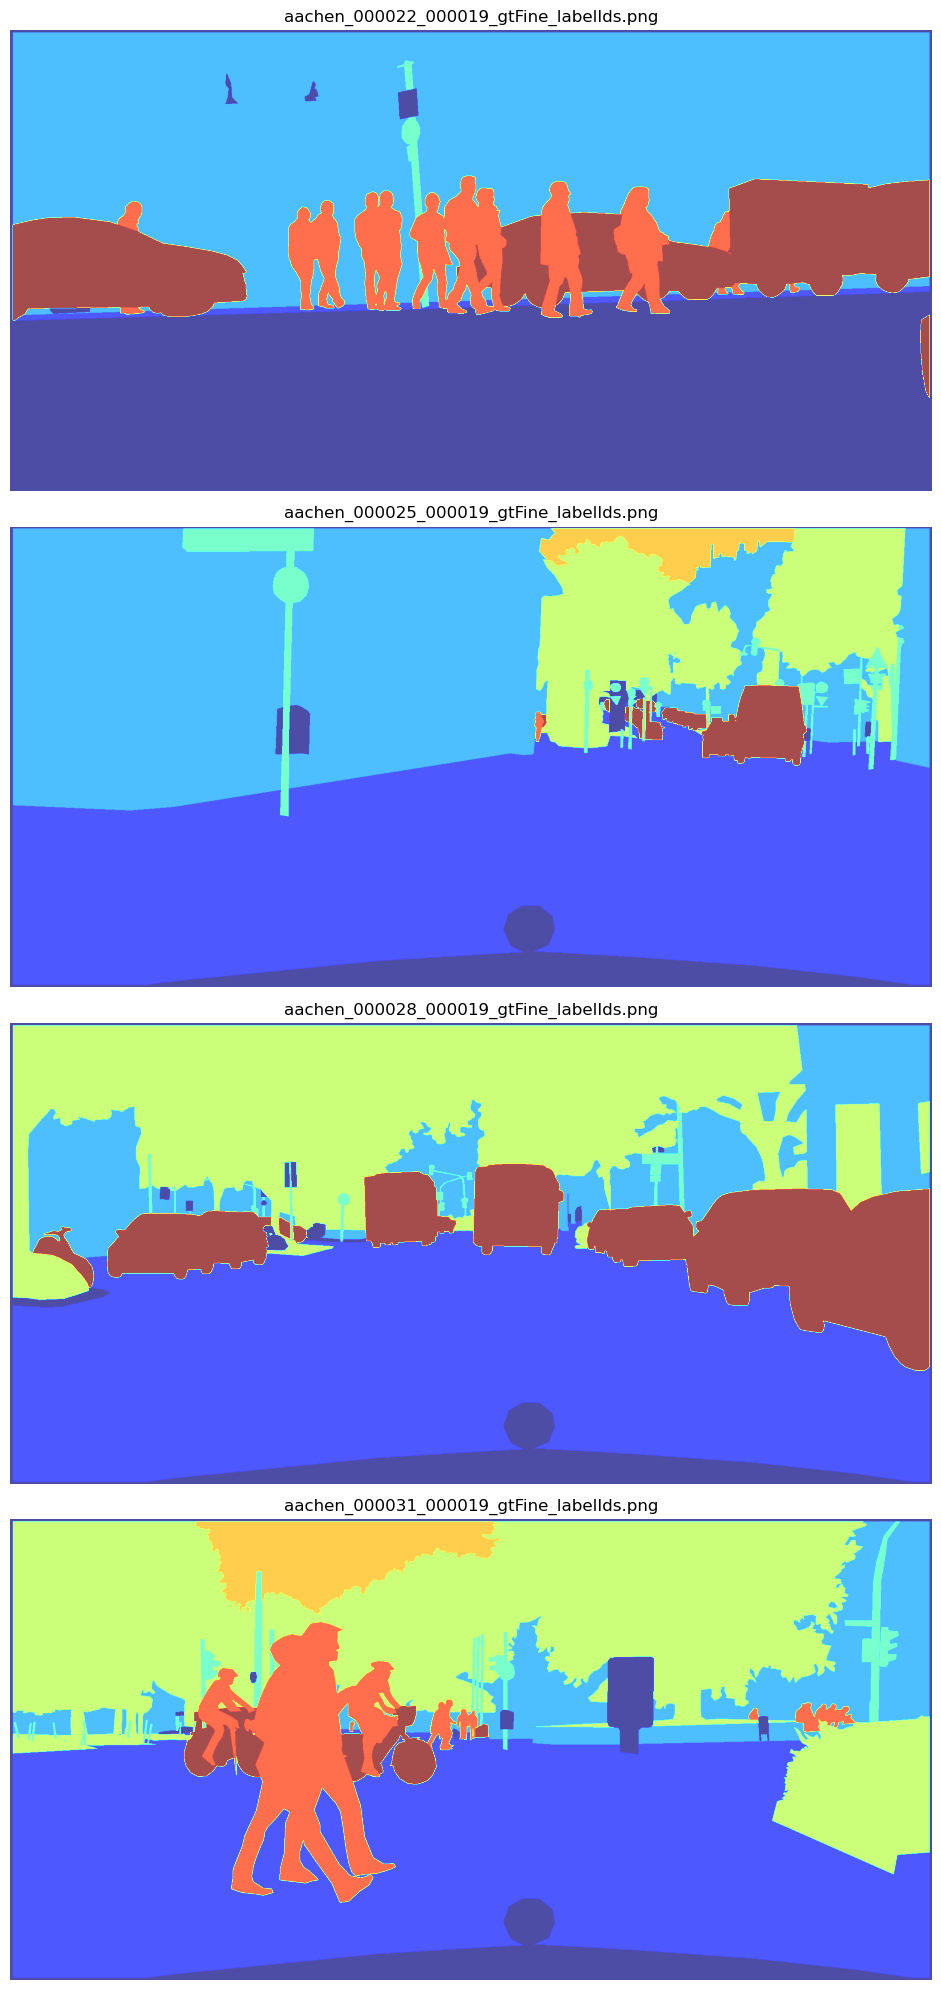

In [262]:
#first we need to load the "training" image set, which will be our working set

# path to train gen_masks repertory
train_gen_mask_path = "data/train/gen_masks"

mask_files = os.listdir(train_gen_mask_path)[:4] #select only the 4 first files

# Display mask
fig, axes = plt.subplots(len(mask_files), 1, figsize=(10, 5 * len(mask_files)))

for i, mask_file in enumerate(mask_files):
    mask = cv2.imread(os.path.join(train_gen_mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(mask, cmap="jet", alpha=0.7)
    axes[i].set_title(mask_file)
    axes[i].axis("off")
    axes[i].set_title(mask_file) #can't display json files

plt.tight_layout()
plt.show()

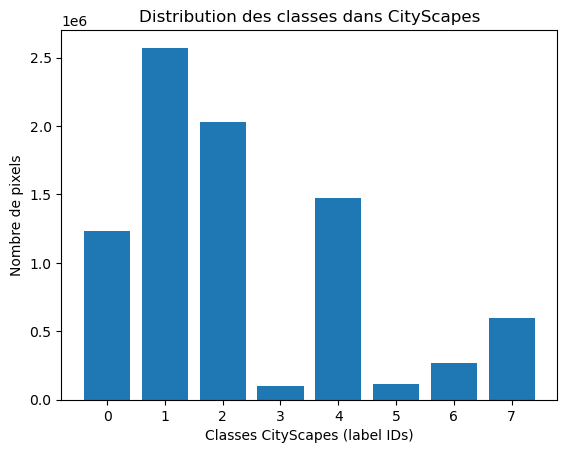

In [267]:
class_counts = Counter()

for mask_file in mask_files:
    if mask_file.endswith("_labelIds.png"):
        mask = cv2.imread(os.path.join(train_gen_mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
        class_counts.update(mask.flatten())

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes CityScapes (label IDs)")
plt.ylabel("Nombre de pixels")
plt.title("Distribution des classes dans CityScapes")
plt.show()

In [284]:
#check is image and masks are of same shape
train_copied_img_path = "data/train/images"
img_files = os.listdir(train_copied_img_path)

mask_shapes = [cv2.imread(os.path.join(train_gen_mask_path, mask), cv2.IMREAD_GRAYSCALE).shape for mask in mask_files[:1]] #check only first
img_shapes = [cv2.imread(os.path.join(train_copied_img_path, file), cv2.IMREAD_GRAYSCALE).shape for file in img_files[:1]]
print("Dimensions des masques :", mask_shapes)
print("Dimensions des images :", img_shapes)

Dimensions des masques : [(1024, 2048)]
Dimensions des images : [(1024, 2048)]


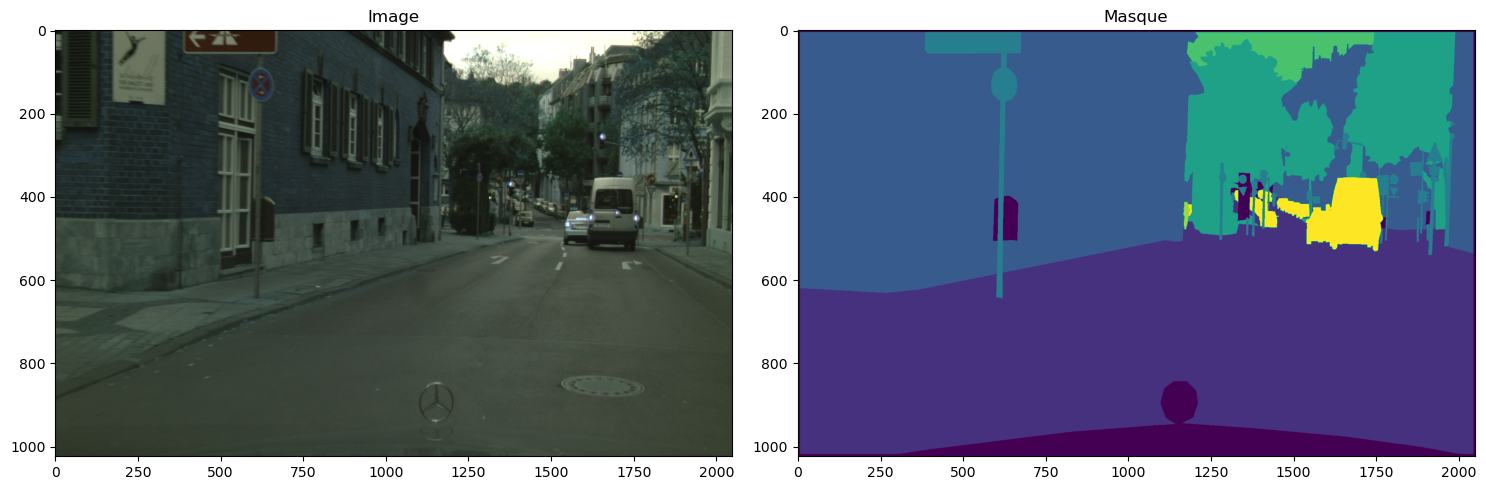

In [40]:
#need to print both images

#display first images and their label
"""for file in selected_files[:2]:
        if file.endswith("_labelIds.png"):    
            file_path = os.path.join(mask_folder, file)
            # with PILLOW
        else:
            file_path = os.path.join(img_folder, file)
"""
train_copied_img_path = "data/train/images"
train_gen_mask_path = "data/train/gen_masks"

img_path = os.path.join(train_copied_img_path, os.listdir(train_copied_img_path)[1])
mask_path = os.path.join(train_gen_mask_path, os.listdir(train_gen_mask_path)[1])

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#visualize images and masks
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img, aspect='auto') 
ax[0].set_title("Image")
ax[1].imshow(mask, aspect='auto')
ax[1].set_title("Masque")
plt.tight_layout()
plt.show()

DONE ! Now back to EDA and baseline models

In [ ]:
#test model saving and loading
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from segmentation_models.base.objects import SumOfLosses
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss, categorical_crossentropy, jaccard_loss 
from segmentation_models.metrics import iou_score
import keras


custom_objects={'SumOfLosses':SumOfLosses,
                'categorical_crossentropy':categorical_crossentropy,
                'jaccard_loss':jaccard_loss,
                'iou_score':iou_score}

model = keras.models.load_model('models_in_progress/first_model.keras', 
                                custom_objects=custom_objects)

"""
TypeError: Unable to reconstruct an instance of 'SumOfLosses' because the class is missing a `from_config()` method. Full object config: {'module': 'segmentation_models.base.objects', 'class_name': 'SumOfLosses', 'config': 'binary_crossentropy_plus_jaccard_loss', 'registered_name': 'SumOfLosses'}
"""
model

#doesn't work due to lack of from_config() method 

In [102]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from segmentation_models.base.objects import SumOfLosses
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss, categorical_crossentropy, jaccard_loss 
from segmentation_models.metrics import iou_score
import keras

from metrics_and_loss import CombinedLoss, IoUMetric

CombinedLoss = CombinedLoss(smooth=100, alpha=0.5)

my_model = keras.models.load_model('models_in_progress/first_model.keras')

In [111]:
#loader function
def load_data(image_dir, mask_dir, img_size=(512, 512), num_classes=8):
    all_images = os.listdir(image_dir)
    all_masks = os.listdir(mask_dir)
    images = []
    masks = []
    
    for img_name in all_images:
        img_path = os.path.join(image_dir, img_name)

        # Load and resize images
        image = cv2.imread(img_path)
        image = cv2.resize(image, img_size)
        images.append(image)
        
    for mask_name in all_masks:
        mask_path = os.path.join(mask_dir, mask_name)
        
        # Load and resize masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
        mask = cv2.resize(mask, img_size)

        # One-hot encode the mask
        mask_one_hot = np.zeros((img_size[0], img_size[1], num_classes))
        for i in range(num_classes):
            mask_one_hot[:, :, i] = (mask == i).astype(int)
        masks.append(mask_one_hot)

    images = np.array(images) / 255 # Normalize images
    masks = np.array(masks)  # Masks are already in one-hot format
    
    return images, masks

In [113]:
image_dir_val = 'data/val/images'
mask_dir_val = 'data/val/gen_masks'
X_val, y_val = load_data(image_dir_val, mask_dir_val, num_classes=8)
X_val.shape

(50, 512, 512, 3)